In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import json

In [2]:
feature_vectors = pd.read_csv('../../../Shapes/full_run/Microglial_Morphology_freeze_run/03_morph_embedding/feature_vectors_texture.csv')
df_vectors = feature_vectors.copy()

In [3]:
# Load the anndata object, calculate distance to nearest granule.

import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm
import scanpy as sc

def calculate_distance_to_granule(adata, region_col='Brain_Region', 
                                  slice_col='batchID', celltype_col='subclass_label_transfer',
                                  x_col='aligned_x', y_col='aligned_y',
                                  cerebellum_type='CB Granule Glut',
                                  hippocampus_type='DG Glut',
                                  new_col='d_to_g'):

    # Subset to relevant regions
    adata_sub = adata[adata.obs[region_col].isin(['Cerebellum', 'Hippocampus'])].copy()
    adata_sub.obs[new_col] = np.nan

    # Get unique (region, batch) combinations
    region_batch_pairs = adata_sub.obs[[region_col, slice_col]].drop_duplicates().values

    for region, batch in tqdm(region_batch_pairs, desc="Processing region-slice pairs"):
        # Subset to this region and batch
        mask = (adata_sub.obs[region_col] == region) & (adata_sub.obs[slice_col] == batch)
        adata_subset = adata_sub[mask]

        # Determine granule cell type
        if region == 'Cerebellum':
            granule_type = cerebellum_type
        elif region == 'Hippocampus':
            granule_type = hippocampus_type
        else:
            print(f"Unknown region '{region}' in batch {batch}. Skipping.")
            continue

        # Coordinates
        coords = adata_subset.obs[[x_col, y_col]].values

        # Find granule cells
        is_granule = adata_subset.obs[celltype_col] == granule_type
        if not np.any(is_granule):
            print(f"No granule cells found in region {region}, batch {batch}. Skipping.")
            continue

        granule_coords = coords[is_granule]
        tree = cKDTree(granule_coords)

        # Nearest neighbor distance
        dists, _ = tree.query(coords)

        # Assign back to main AnnData
        adata_sub.obs.loc[adata_subset.obs.index, new_col] = dists

    return adata_sub

In [4]:
adata = sc.read_h5ad('ABC_cleaned.h5ad')

#wanting to make sure we only show the neurons with a high confidence
adata_HQ = adata[adata.obs.subclass_label_confidence > 0.8]

adata_HQ.X = adata_HQ.layers['counts'].toarray().copy()
sc.pp.normalize_total(adata_HQ)
sc.pp.log1p(adata_HQ)

adata_HQ = adata_HQ[adata_HQ.obs.Brain_Region.isin(['Cerebellum', 'Hippocampus'])]

adata_HQ = calculate_distance_to_granule(adata_HQ, region_col='Brain_Region', 
                                  slice_col='batchID', celltype_col='subclass_label_transfer',
                                  x_col='aligned_x', y_col='aligned_y',
                                  cerebellum_type='CB Granule Glut',
                                  hippocampus_type='DG Glut',
                                  new_col='d_to_g')

/oak/stanford/groups/quake/doug/resources/miniconda3/envs/Vizgen_2/lib/python3.9/site-packages/anndata/_core/anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/oak/stanford/groups/quake/doug/resources/miniconda3/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
Processing region-slice pairs: 100%|██████████| 22/22 [00:01<00:00, 15.60it/s]


In [5]:
mic_adata = adata_HQ[adata_HQ.obs.subclass_label_transfer == 'Microglia NN']

In [6]:
merged_df = mic_adata.obs.reset_index().merge(df_vectors, on=['Name'], how='left').set_index('CellID')
mic_adata.obs = merged_df

start_index = list(mic_adata.obs.columns).index('Cell Area')
columns_after_specific = mic_adata.obs.iloc[:, start_index:-3].values

morphological_columns = mic_adata.obs.columns[start_index:-3]

start_index = list(mic_adata.obs.columns).index('Cell Area')  # Add 1 to include the column itself
columns_after_specific = mic_adata.obs.iloc[:, start_index:-3].values

morphological_columns = mic_adata.obs.columns[start_index:-3]

non_na_columns = morphological_columns[~mic_adata.obs[morphological_columns].isna().all()]

# Identify rows with any NaN values in the morphological factors
rows_with_nan = mic_adata.obs[non_na_columns].isna().all(axis=1)

# Subset the AnnData object to remove rows with NaN values
mic_adata = mic_adata[~rows_with_nan].copy()

In [7]:
mic_adata = mic_adata[mic_adata.obs.d_to_g < 100]

In [8]:
def region_specific_correlations_by_age(
    adata,
    morph_cols,
    distance_col='d_to_g',
    region_col='Brain_Region',
    age_col='Age',
    method='spearman'
):
    """
    Calculate correlations between morphological features and d_to_g for each Region x Age group.
    """
    from scipy.stats import spearmanr, pearsonr
    import pandas as pd
    import numpy as np

    results = []

    # Fix the column selection
    cols = [region_col, age_col] + list(morph_cols) + [distance_col]
    grouped = adata.obs[cols].dropna()

    for (region, age), df_group in grouped.groupby([region_col, age_col]):
        for morph_col in morph_cols:
            x = df_group[distance_col]
            y = df_group[morph_col]

            valid = x.notna() & y.notna()
            x_valid, y_valid = x[valid], y[valid]

            if len(x_valid) < 3:
                corr, pval = np.nan, np.nan
            else:
                if method == 'spearman':
                    corr, pval = spearmanr(x_valid, y_valid)
                elif method == 'pearson':
                    corr, pval = pearsonr(x_valid, y_valid)
                else:
                    raise ValueError("Method must be 'spearman' or 'pearson'.")

            results.append({
                'Region': region,
                'Age': age,
                'Morphological_Feature': morph_col,
                'Correlation': corr,
                'P-value': pval
            })

    return pd.DataFrame(results)

def region_specific_correlations_by_age_batched(
    adata,
    morph_cols,
    distance_col='d_to_g',
    region_col='Brain_Region',
    age_col='Age',
    batch_col='batchID',
    method='spearman'
):
    """
    Calculate correlation between distance and morphological features per Region × Age,
    using batch-averaged (bulked) data.
    """
    from scipy.stats import spearmanr, pearsonr
    import pandas as pd
    import numpy as np

    results = []

    # Drop missing values before aggregation
    cols = [region_col, age_col, batch_col, distance_col] + list(morph_cols)
    df = adata.obs[cols].dropna()

    # Aggregate (bulk) per batch
    df_batched = df.groupby([region_col, age_col, batch_col]).agg(
        {distance_col: 'mean', **{col: 'mean' for col in morph_cols}}
    ).reset_index()

    # Loop over Region × Age groups
    for (region, age), df_group in df_batched.groupby([region_col, age_col]):
        for morph_col in morph_cols:
            x = df_group[distance_col]
            y = df_group[morph_col]

            valid = x.notna() & y.notna()
            x_valid = x[valid]
            y_valid = y[valid]

            if len(x_valid) < 3:
                corr, pval = np.nan, np.nan
            else:
                if method == 'spearman':
                    corr, pval = spearmanr(x_valid, y_valid)
                elif method == 'pearson':
                    corr, pval = pearsonr(x_valid, y_valid)
                else:
                    raise ValueError("Method must be 'spearman' or 'pearson'.")

            results.append({
                'Region': region,
                'Age': age,
                'Morphological_Feature': morph_col,
                'Correlation': corr,
                'P-value': pval,
                'N_Batches': len(x_valid)
            })

    return pd.DataFrame(results)

def binned_correlation_by_group(
    adata,
    morph_cols,
    distance_col='d_to_g',
    region_col='Brain_Region',
    age_col='Age',
    batch_col='batchID',
    bin_width=10,
    bin_start=0,
    method='spearman',
    avg_across_batches=False  # <-- NEW
):
    """
    Compute correlations between d_to_g and morphology features using binned distances.
    Optionally average across batches (per group/bin) or retain per-batch resolution.
    """
    from scipy.stats import spearmanr, pearsonr
    import pandas as pd
    import numpy as np

    # Step 1: Clean data
    cols = [distance_col, region_col, age_col, batch_col] + list(morph_cols)
    df = adata.obs[cols].dropna()

    # Step 2: Bin distances
    max_dist = df[distance_col].max()
    bin_edges = np.arange(bin_start, max_dist + bin_width, bin_width)
    df['Distance_Bin'] = pd.cut(df[distance_col], bins=bin_edges)

    # Step 3: Grouping strategy
    if avg_across_batches:
        group_cols = [region_col, age_col, 'Distance_Bin']
    else:
        group_cols = [region_col, age_col, batch_col, 'Distance_Bin']

    agg_cols = {col: 'mean' for col in morph_cols}
    agg_cols[distance_col] = 'mean'

    df_avg = (
        df.groupby(group_cols)
          .agg(agg_cols)
          .reset_index()
          .dropna()
    )

    # Label group
    df_avg['Group'] = df_avg[region_col].astype(str) + ' | ' + df_avg[age_col].astype(str)

    # Step 4: Correlation per group × morph feature
    results = []

    for group, group_df in df_avg.groupby('Group'):
        for morph in morph_cols:
            x = group_df[distance_col]
            y = group_df[morph]

            valid = x.notna() & y.notna()
            x_valid = x[valid]
            y_valid = y[valid]

            if len(x_valid) < 3:
                corr, pval = np.nan, np.nan
            else:
                if method == 'spearman':
                    corr, pval = spearmanr(x_valid, y_valid)
                elif method == 'pearson':
                    corr, pval = pearsonr(x_valid, y_valid)
                else:
                    raise ValueError("method must be 'spearman' or 'pearson'")

            region, age = group_df[[region_col, age_col]].iloc[0]

            results.append({
                'Region': region,
                'Age': age,
                'Group': group,
                'Morphological_Feature': morph,
                'Correlation': corr,
                'P-value': pval,
                'N_Bins': len(x_valid)
            })

    return pd.DataFrame(results)

In [9]:
df_corr = region_specific_correlations_by_age(mic_adata, morphological_columns, distance_col='d_to_g', region_col='Brain_Region',age_col='Age', method='pearson')

/tmp/ipykernel_19132/802710904.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for (region, age), df_group in grouped.groupby([region_col, age_col]):
/tmp/ipykernel_19132/802710904.py:36: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = pearsonr(x_valid, y_valid)


In [10]:
df_corr = binned_correlation_by_group(mic_adata,morphological_columns, method='spearman',avg_across_batches=True)

/tmp/ipykernel_19132/802710904.py:148: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(group_cols)
/tmp/ipykernel_19132/802710904.py:173: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = spearmanr(x_valid, y_valid)
/tmp/ipykernel_19132/802710904.py:173: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = spearmanr(x_valid, y_valid)
/tmp/ipykernel_19132/802710904.py:173: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = spearmanr(x_valid, y_valid)
/tmp/ipykernel_19132/802710904.py:173: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, pval = spearmanr(x_valid, y_val

In [11]:
def plot_corr_heatmap(df_corr):
    heatmap_data = df_corr.pivot(index='Morphological_Feature', columns='Region', values='Correlation')
    
    sns.heatmap(heatmap_data, annot=True, cmap='vlag', center=0, linewidths=0.5)
    plt.title('Correlation Between Morphology and Distance to Granule Cell')
    plt.xlabel('Brain Region')
    plt.ylabel('Morphological Feature')
    plt.tight_layout()
    plt.show()
    
def plot_corr_dotplot(df_corr, sig_level=0.05):
    plt.figure(figsize=(10, len(df_corr['Morphological_Feature'].unique()) * 0.5 + 2))
    sns.scatterplot(
        data=df_corr,
        x='Region',
        y='Morphological_Feature',
        size=-np.log10(df_corr['P-value']),
        hue='Correlation',
        palette='vlag',
        sizes=(50, 300),
        edgecolor='black'
    )
    plt.axhline(y=-1, color='gray', linestyle='--')
    plt.title('Region-Specific Correlation: Morphology vs. Distance to Granule')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show() 
    
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

def scatter_with_fit_and_r2(adata, morph_feature, distance_col='d_to_g', region_col='Brain_Region', ax=None):
    """
    Plot scatter of distance to granule vs morphological feature with regression lines and R² per region.
    """
    df = adata.obs[[morph_feature, distance_col, region_col]].dropna()

    plt.figure(figsize=(8, 6))
    ax = ax or plt.gca()

    # Palette
    palette = sns.color_palette("Set2", df[region_col].nunique())

    # Plot scatter and fit line per region
    for i, region in enumerate(df[region_col].unique()):
        df_region = df[df[region_col] == region]
        x = df_region[distance_col].values.reshape(-1, 1)
        y = df_region[morph_feature].values

        # Fit linear regression
        model = LinearRegression().fit(x, y)
        y_pred = model.predict(x)
        r2 = r2_score(y, y_pred)

        # Plot scatter
        sns.scatterplot(x=df_region[distance_col], y=df_region[morph_feature], 
                        label=f"{region} (R² = {r2:.2f})", ax=ax, color=palette[i], alpha=0.5)

        # Plot line of best fit
        sort_idx = np.argsort(x.flatten())
        ax.plot(x[sort_idx], y_pred[sort_idx], color=palette[i], linewidth=2)

    ax.set_xlabel('Distance to Granule Cell')
    ax.set_ylabel(morph_feature)
    ax.set_title(f'{morph_feature} vs. Distance to Granule Cell by Region')
    ax.legend()
    plt.tight_layout()
    plt.show()
    
def scatter_with_fit_and_r2_batch_averaged_by_age(
    adata,
    morph_feature,
    distance_col='d_to_g',
    region_col='Brain_Region',
    age_col='Age',               # <-- NEW
    batch_col='batchID',
    ax=None
):
    """
    Plot scatter of batch-averaged distance to granule vs. morphological feature,
    with regression lines and R² per (region, age) group.
    """
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Extract and clean data
    df = adata.obs[[morph_feature, distance_col, region_col, age_col, batch_col]].copy()
    df = df.dropna(subset=[morph_feature, distance_col, region_col, age_col, batch_col])

    # Compute batch-averaged means grouped by region + age
    df_avg = df.groupby([region_col, age_col, batch_col]).agg({
        morph_feature: 'mean',
        distance_col: 'mean'
    }).reset_index()

    # Drop any NaNs that appeared post-aggregation
    df_avg = df_avg.dropna(subset=[morph_feature, distance_col])

    plt.figure(figsize=(9, 6))
    ax = ax or plt.gca()

    # Create a label for each group: e.g., "Cerebellum | P30"
    df_avg['group'] = df_avg[region_col].astype(str) + ' | ' + df_avg[age_col].astype(str)

    # Create color palette
    unique_groups = df_avg['group'].unique()
    palette = dict(zip(unique_groups, sns.color_palette("tab10", len(unique_groups))))

    for group in unique_groups:
        df_group = df_avg[df_avg['group'] == group]

        # Drop any NaNs
        x = df_group[distance_col].values
        y = df_group[morph_feature].values
        valid = ~np.isnan(x) & ~np.isnan(y)
        x = x[valid].reshape(-1, 1)
        y = y[valid]

        if len(x) == 0 or len(y) == 0:
            continue

        # Linear fit and R²
        model = LinearRegression().fit(x, y)
        y_pred = model.predict(x)
        r2 = r2_score(y, y_pred)

        # Scatter plot and line
        sns.scatterplot(
            x=x.flatten(),
            y=y,
            label=f"{group} (R² = {r2:.2f})",
            ax=ax,
            color=palette[group],
            s=80,
            edgecolor='black'
        )
        sort_idx = np.argsort(x.flatten())
        ax.plot(x.flatten()[sort_idx], y_pred[sort_idx], color=palette[group], linewidth=2)

    ax.set_xlabel('Average Distance to Granule Cell (per batch)')
    ax.set_ylabel(f'Average {morph_feature} (per batch)')
    ax.set_title(f'{morph_feature} vs. d_to_g (Batch-Averaged by Region & Age)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
def plot_corr_heatmap_by_age(df_corr):

    # Create a combined column for Region + Age
    df_corr['Region_Age'] = df_corr['Region'] + ' | ' + df_corr['Age'].astype(str)

    # Pivot to wide format: Morphological_Feature x Region_Age
    heatmap_data = df_corr.pivot(index='Morphological_Feature', columns='Region_Age', values='Correlation')

    # Sort columns nicely if needed
    heatmap_data = heatmap_data[sorted(heatmap_data.columns)]

    # Plot single heatmap
    plt.figure(figsize=(0.5 * heatmap_data.shape[1], 0.5 * heatmap_data.shape[0] + 4))
    sns.heatmap(
        heatmap_data,
        annot=False,
        cmap='vlag',
        center=0,
        linewidths=0.5,
        cbar_kws={'label': 'Spearman Correlation'}
    )

    plt.title('Morphology vs. d_to_g Correlation Heatmap by Region & Age')
    plt.xlabel('Region | Age')
    plt.ylabel('Morphological Feature')
    plt.tight_layout()
    plt.show()
    
def plot_corr_dotplot_by_age(df_corr, sig_level=0.05):

    plt.figure(figsize=(12, len(df_corr['Morphological_Feature'].unique()) * 0.5 + 3))
    sns.scatterplot(
        data=df_corr,
        x='Region',
        y='Morphological_Feature',
        size=-np.log10(df_corr['P-value']),
        hue='Correlation',
        style='Age',  # 👈 adds shape per age group
        palette='vlag',
        sizes=(50, 300),
        edgecolor='black'
    )

    plt.title('Correlation of Morphology vs. d_to_g by Region and Age')
    plt.xlabel('Region')
    plt.ylabel('Morphological Feature')
    plt.axhline(y=-1, color='gray', linestyle='--')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Correlation / Age / Significance')
    plt.tight_layout()
    plt.show()
    
def scatter_and_compare_slopes_by_group(
    adata,
    morph_feature,
    distance_col='d_to_g',
    region_col='Brain_Region',
    age_col='Age',
    batch_col='batchID',
    ax=None
):
    """
    Plot batch-averaged morphology vs. distance with regression lines and R² per (region, age),
    and return slope estimates and pairwise comparisons with p-values.
    """
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score
    from scipy import stats
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Step 1: Clean and average
    df = adata.obs[[morph_feature, distance_col, region_col, age_col, batch_col]].copy()
    df = df.dropna(subset=[morph_feature, distance_col, region_col, age_col, batch_col])

    df_avg = df.groupby([region_col, age_col, batch_col]).agg({
        morph_feature: 'mean',
        distance_col: 'mean'
    }).reset_index()

    df_avg = df_avg.dropna(subset=[morph_feature, distance_col])
    df_avg['group'] = df_avg[region_col].astype(str) + ' | ' + df_avg[age_col].astype(str)

    # Plot setup
    plt.figure(figsize=(9, 6))
    ax = ax or plt.gca()

    unique_groups = df_avg['group'].unique()
    palette = dict(zip(unique_groups, sns.color_palette("tab10", len(unique_groups))))

    slope_records = []

    for group in unique_groups:
        df_group = df_avg[df_avg['group'] == group]

        # NaN-safe filtering
        df_valid = df_group[[distance_col, morph_feature]].replace([np.inf, -np.inf], np.nan).dropna()
        if len(df_valid) < 3:
            continue

        x = df_valid[distance_col].values.reshape(-1, 1)
        y = df_valid[morph_feature].values

        # Fit regression
        model = LinearRegression().fit(x, y)
        y_pred = model.predict(x)
        r2 = r2_score(y, y_pred)
        slope = model.coef_[0]

        # Standard error of the slope
        residuals = y - y_pred
        s_err = np.sqrt(np.sum(residuals ** 2) / (len(x) - 2))
        x_centered = x.flatten() - np.mean(x)
        se = s_err / np.sqrt(np.sum(x_centered ** 2))

        # Save slope info
        slope_records.append({
            'Group': group,
            'Region': df_group[region_col].iloc[0],
            'Age': df_group[age_col].iloc[0],
            'Slope': slope,
            'SE': se,
            'R²': r2,
            'N_Batches': len(df_valid)
        })

        # Plot
        sns.scatterplot(
            x=x.flatten(),
            y=y,
            label=f"{group} (R² = {r2:.2f})",
            ax=ax,
            color=palette[group],
            s=80,
            edgecolor='black'
        )
        sort_idx = np.argsort(x.flatten())
        ax.plot(x.flatten()[sort_idx], y_pred[sort_idx], color=palette[group], linewidth=2)

    ax.set_xlabel('Average Distance to Granule Cell (per batch)')
    ax.set_ylabel(f'Average {morph_feature} (per batch)')
    ax.set_title(f'{morph_feature} vs. d_to_g (Batch-Averaged by Region & Age)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Step 2: Compare slopes pairwise
    slope_df = pd.DataFrame(slope_records)
    pairwise = []

    for i in range(len(slope_df)):
        for j in range(i + 1, len(slope_df)):
            g1 = slope_df.iloc[i]
            g2 = slope_df.iloc[j]

            diff = g1['Slope'] - g2['Slope']
            se_diff = np.sqrt(g1['SE'] ** 2 + g2['SE'] ** 2)
            z = diff / se_diff if se_diff > 0 else np.nan
            p = 2 * (1 - stats.norm.cdf(abs(z))) if not np.isnan(z) else np.nan

            pairwise.append({
                'Group1': g1['Group'],
                'Group2': g2['Group'],
                'Slope1': g1['Slope'],
                'Slope2': g2['Slope'],
                'Slope_Diff': diff,
                'SE_Diff': se_diff,
                'Z': z,
                'P-value': p
            })

    pairwise_df = pd.DataFrame(pairwise)
    
    plt.figure(figsize=(max(6, 0.8 * len(slope_df)), 5))
    sns.barplot(
        data=slope_df,
        x='Group',
        y='Slope',
        palette=palette,
        ci=None,
        edgecolor='black',
        linewidth=1.2
    )
    plt.errorbar(
        x=np.arange(len(slope_df)),
        y=slope_df['Slope'],
        yerr=slope_df['SE'],
        fmt='none',
        ecolor='black',
        capsize=5,
        capthick=1.2
    )
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Slope (Morphology ~ Distance)')
    plt.title(f'Slope ± SE per Group: {morph_feature}')
    plt.tight_layout()
    plt.show()

    return slope_df, pairwise_df

def scatter_and_compare_slopes_binned_by_distance(
    adata,
    morph_feature,
    distance_col='d_to_g',
    region_col='Brain_Region',
    age_col='Age',
    batch_col='batchID',
    bin_width=10,
    bin_start=0,
    avg_across_batches=False,  # <-- NEW
    ax=None
):
    """
    Bin distances (e.g., 0–10, 10–20...) and compute morphology averages.
    If avg_across_batches=True, average per bin across batches (1 point per bin per group).
    Otherwise, keep one point per bin per batch (default).
    Then fit regressions per group and compare slopes.
    """
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score
    from scipy import stats
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Step 1: Clean and bin
    df = adata.obs[[morph_feature, distance_col, region_col, age_col, batch_col]].copy()
    df = df.dropna(subset=[morph_feature, distance_col, region_col, age_col, batch_col])

    max_dist = df[distance_col].max()
    bin_edges = np.arange(bin_start, max_dist + bin_width, bin_width)
    df['Distance_Bin'] = pd.cut(df[distance_col], bins=bin_edges)

    # Grouping
    if avg_across_batches:
        group_cols = [region_col, age_col, 'Distance_Bin']
    else:
        group_cols = [region_col, age_col, batch_col, 'Distance_Bin']

    df_avg = (
        df.groupby(group_cols)
          .agg({distance_col: 'mean', morph_feature: 'mean'})
          .reset_index()
    )

    df_avg = df_avg.dropna(subset=[morph_feature, distance_col])
    df_avg['group'] = df_avg[region_col].astype(str) + ' | ' + df_avg[age_col].astype(str)

    # Plot setup
    plt.figure(figsize=(9, 6))
    ax = ax or plt.gca()

    unique_groups = df_avg['group'].unique()
    palette = dict(zip(unique_groups, sns.color_palette("tab10", len(unique_groups))))
    slope_records = []

    for group in unique_groups:
        df_group = df_avg[df_avg['group'] == group]

        df_valid = df_group[[distance_col, morph_feature]].replace([np.inf, -np.inf], np.nan).dropna()
        if len(df_valid) < 3:
            continue

        x = df_valid[distance_col].values.reshape(-1, 1)
        y = df_valid[morph_feature].values

        model = LinearRegression().fit(x, y)
        y_pred = model.predict(x)
        r2 = r2_score(y, y_pred)
        slope = model.coef_[0]

        residuals = y - y_pred
        s_err = np.sqrt(np.sum(residuals ** 2) / (len(x) - 2))
        x_centered = x.flatten() - np.mean(x)
        se = s_err / np.sqrt(np.sum(x_centered ** 2))

        slope_records.append({
            'Group': group,
            'Region': df_group[region_col].iloc[0],
            'Age': df_group[age_col].iloc[0],
            'Slope': slope,
            'SE': se,
            'R²': r2,
            'N_Points': len(df_valid)
        })

        sns.scatterplot(
            x=x.flatten(),
            y=y,
            label=f"{group} (R² = {r2:.2f})",
            ax=ax,
            color=palette[group],
            s=80,
            edgecolor='black'
        )
        sort_idx = np.argsort(x.flatten())
        ax.plot(x.flatten()[sort_idx], y_pred[sort_idx], color=palette[group], linewidth=2)

    ax.set_xlabel(f'Average {distance_col} per bin')
    ax.set_ylabel(f'Average {morph_feature} per bin')
    ax.set_title(f'{morph_feature} vs. {distance_col} (Binned{" Across Batches" if avg_across_batches else ""})')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Step 2: Pairwise slope comparisons
    slope_df = pd.DataFrame(slope_records)
    pairwise = []
    for i in range(len(slope_df)):
        for j in range(i + 1, len(slope_df)):
            g1 = slope_df.iloc[i]
            g2 = slope_df.iloc[j]

            diff = g1['Slope'] - g2['Slope']
            se_diff = np.sqrt(g1['SE'] ** 2 + g2['SE'] ** 2)
            z = diff / se_diff if se_diff > 0 else np.nan
            p = 2 * (1 - stats.norm.cdf(abs(z))) if not np.isnan(z) else np.nan

            pairwise.append({
                'Group1': g1['Group'],
                'Group2': g2['Group'],
                'Slope1': g1['Slope'],
                'Slope2': g2['Slope'],
                'Slope_Diff': diff,
                'SE_Diff': se_diff,
                'Z': z,
                'P-value': p
            })

    pairwise_df = pd.DataFrame(pairwise)

    # Step 3: Bar plot with SE
    plt.figure(figsize=(max(6, 0.8 * len(slope_df)), 5))
    sns.barplot(
        data=slope_df,
        x='Group',
        y='Slope',
        palette=palette,
        ci=None,
        edgecolor='black',
        linewidth=1.2
    )
    plt.errorbar(
        x=np.arange(len(slope_df)),
        y=slope_df['Slope'],
        yerr=slope_df['SE'],
        fmt='none',
        ecolor='black',
        capsize=5,
        capthick=1.2
    )
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Slope (Morphology ~ Distance)')
    plt.title(f'Slope ± SE per Group: {morph_feature} (Binned{" Avg" if avg_across_batches else ""})')
    plt.tight_layout()
    plt.show()

    return slope_df, pairwise_df


In [12]:
def plot_corr_barplot_by_age(df_corr, hue_by='Region', zscore=False, save_pdf=False):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np

    # Combine Region and Age
    df_corr['Region_Age'] = df_corr['Region'] + ' | ' + df_corr['Age'].astype(str)

    # Pivot to wide format
    heatmap_data = df_corr.pivot(index='Morphological_Feature',
                                 columns='Region_Age',
                                 values='Correlation').loc[:, sorted(df_corr['Region_Age'].unique())]

    # Optional z-scoring
    if zscore:
        heatmap_data = heatmap_data.subtract(heatmap_data.mean(axis=1), axis=0)
        heatmap_data = heatmap_data.divide(heatmap_data.std(axis=1), axis=0)

    # Melt to long‐form
    bar_data = (
        heatmap_data.reset_index()
        .melt(id_vars='Morphological_Feature',
              var_name='Region_Age',
              value_name='Correlation')
    )
    bar_data[['Region', 'Age']] = bar_data['Region_Age'].str.split(' \| ', expand=True)
    bar_data['Age'] = bar_data['Age'].astype(str)

    # ---------- CHANGED: order by correlation in Age == 24 ----------
    order_source = (
        bar_data.loc[bar_data['Age'] == '3', ['Morphological_Feature', 'Correlation']]
        .sort_values('Correlation', ascending=False)
    )
    feature_order = order_source['Morphological_Feature'].tolist()
    bar_data['Morphological_Feature'] = pd.Categorical(
        bar_data['Morphological_Feature'],
        categories=feature_order,
        ordered=True
    )
    # ---------------------------------------------------------------

    # Plot
    plt.figure(figsize=(max(8, len(feature_order) * 0.6), 6))
    sns.barplot(data=bar_data,
                x='Morphological_Feature',
                y='Correlation',
                hue=hue_by,
                palette='viridis',
                edgecolor='black')
    plt.xticks(rotation=90, ha='center')
    plt.title('Morphology vs. d_to_g Correlation Barplot' + (' (Z-scored)' if zscore else ''))
    plt.ylabel('Z-scored' if zscore else 'Spearman Correlation')
    plt.xlabel('Morphological Feature')
    plt.tight_layout()
    if save_pdf:
        plt.savefig(save_pdf, format='pdf')
    plt.show()

In [13]:
df_corr = df_corr[~df_corr['Morphological_Feature'].isin(['Radius of Influence','Soma Area','Soma Perimeter','Soma Ratio','Soma Circularity','Normalized Intensity'])]

In [14]:
df_cb = df_corr[df_corr.Region == 'Cerebellum']

/tmp/ipykernel_19132/1842656830.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corr['Region_Age'] = df_corr['Region'] + ' | ' + df_corr['Age'].astype(str)


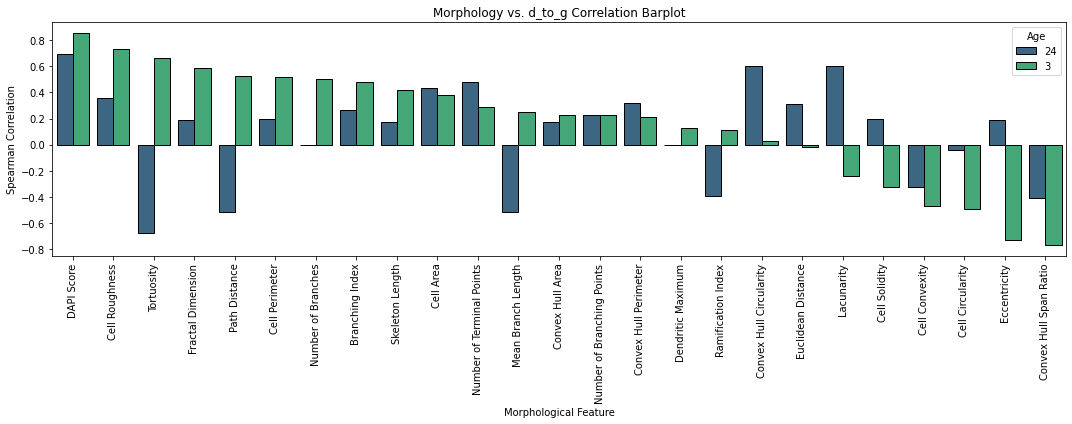

In [15]:
plot_corr_barplot_by_age(df_cb,hue_by='Age',zscore=False,save_pdf='IHC_Valid/Measurements.pdf')